# Optimal Private Minimim Spanning Trees using Input Perturbation

## General Information

TODO Write more here.

* We are using $\rho$-zCDP.

**PAMST** (Pinot 2018): Uses the Private A Minimum Spanning Tree algorithm due to Pinot

**Sealfon**: Uses the Post-Processing approach suggested by Sealfon. 

**We** Modification of Sealfon.


In [14]:
import logging
logger = logging.getLogger(__name__)

import math, sys, random
from statistics import median
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from src.mst.pamst import pamst, comp_mst_weight
from src.mst.mst_utilities import compute_real_mst_weight, generate_random_complete_graph, compute_input_perturbation, generate_hard_instance, compute, generate_mi_instance

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})
if sys.version_info[0:2] != (3, 9):
    logger.warning("This script has only been tested on python 3.9")

In [24]:
# Computing Private Minimum Spanning Trees using Different Algorithms, Using l_infty neighboroing relationsip

# Privacy Parameters
#rho_values = [0.1,0.015,0.2,0.375,0.5,1,2,4,6,10, 100, 200]
#rho_values = np.arange(0.001, 100000, 5000)
n = 100
# Experiment with random graph

#rho_values = np.arange(20000, 100000, 5000)
#sensitivity = 1
#G = generate_random_complete_graph(n, range=1)
# IMPORTANT:: Something is wrong with the PAMST IMPLEMENTAION

# Second experiment
#rho_values = np.arange(0.01, 3, 0.005)
#sensitivity = 0.00996578428 # MI for dataset of size 1000 
#sensitivity = 0.01# MI for dataset of size 1000 
#G = generate_mi_instance(150,0.05)
# Sealfon seems to to good on this instance?

# Thirds: Hard Instance

rho_values = np.arange(0.001, 20, 0.0025)
sensitivity = 1 # MI for dataset of size 1000 
G = generate_hard_instance(150, math.sqrt(150))

upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n/(2*rho))]
    
results = compute(G=G, sensitivity=sensitivity, rho_values=rho_values)

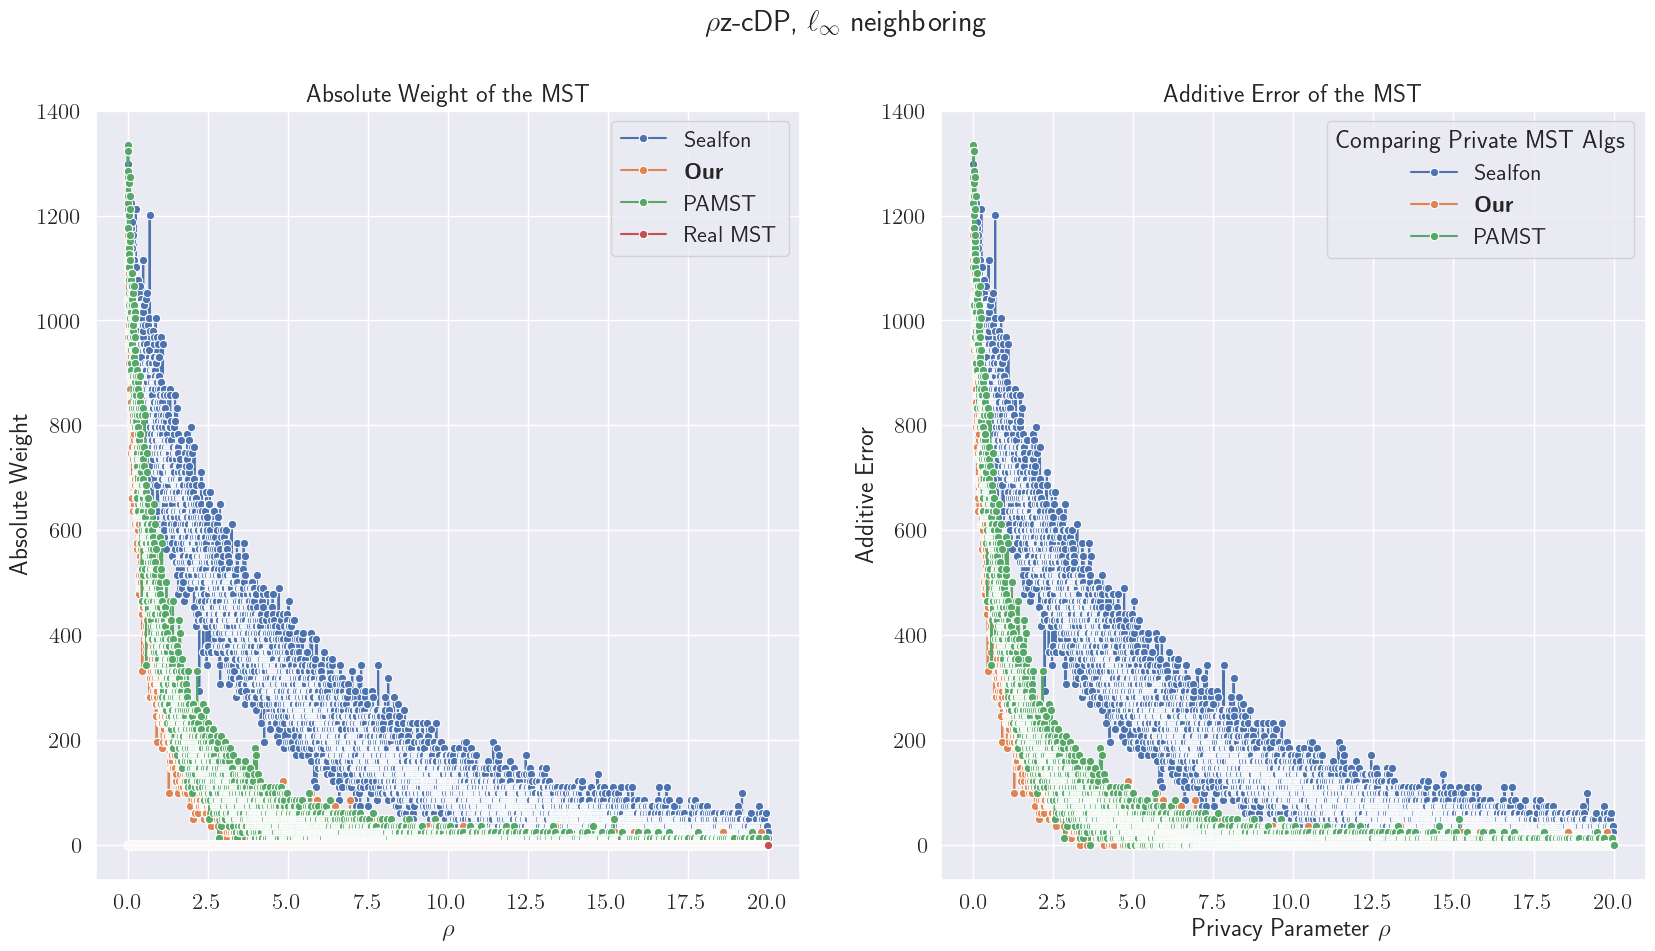

In [27]:
# Visualizing the previously setup result

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

## Convert all the element to max spanning tree
#(sealfon, our, pamst, real) = ([i * -1 for i in results['sealfon']],
#                               [i * -1 for i in results['our']], 
#                               [i * -1 for i in results['pamst']],
#                               [i * -1 for i in results['real']])
(sealfon, our, pamst, real) = (results['sealfon'], results['our'], results['pamst'], results['real'])

# Error of the MST
sns.lineplot(x= rho_values, y=sealfon,marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x= rho_values, y=our, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x= rho_values, y=pamst, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x= rho_values, y=real, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")
# Error of the MST
sns.lineplot(x= rho_values, y=[sealfon - real for sealfon, real in zip(sealfon, real)] ,marker='o', label="Sealfon", ax=axs[1])
sns.lineplot(x= rho_values, y=[ours - real for ours, real in zip(our, real)] , marker='o', label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x= rho_values, y=[pamst - real for pamst, real in zip(results['pamst'], real)] , marker='o', label="PAMST", ax=axs[1])

axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
#axs[0].set_ylim([0,100])

axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title = "Comparing Private MST Algs")
plt.show()


# Experiments on Hard Instances
We are using Sealfons instance to create an hard instance.

Real MST Weight: 0
[255.88914266403188, 73.5649455387632, 50.96985726099633, 48.898288115691514, 40.195514048130924, 34.16505878569597, 31.81082745181895, 29.132528646722648, 27.275005516515087, 25.888733459683117, 23.241404955174975, 24.005504874179696, 23.533145255571643, 20.797337860565584, 21.92562109770431, 19.855406679112214, 18.290899885832246, 17.861791252409123, 17.803689066680995, 18.946081296922554, 17.6292836437288, 17.30887690144163, 16.712589523084713, 17.22781066524305, 16.195769814656874, 16.151579466303254, 15.0103480695772, 15.72490444887349, 12.868806022550247, 15.174911470724657]


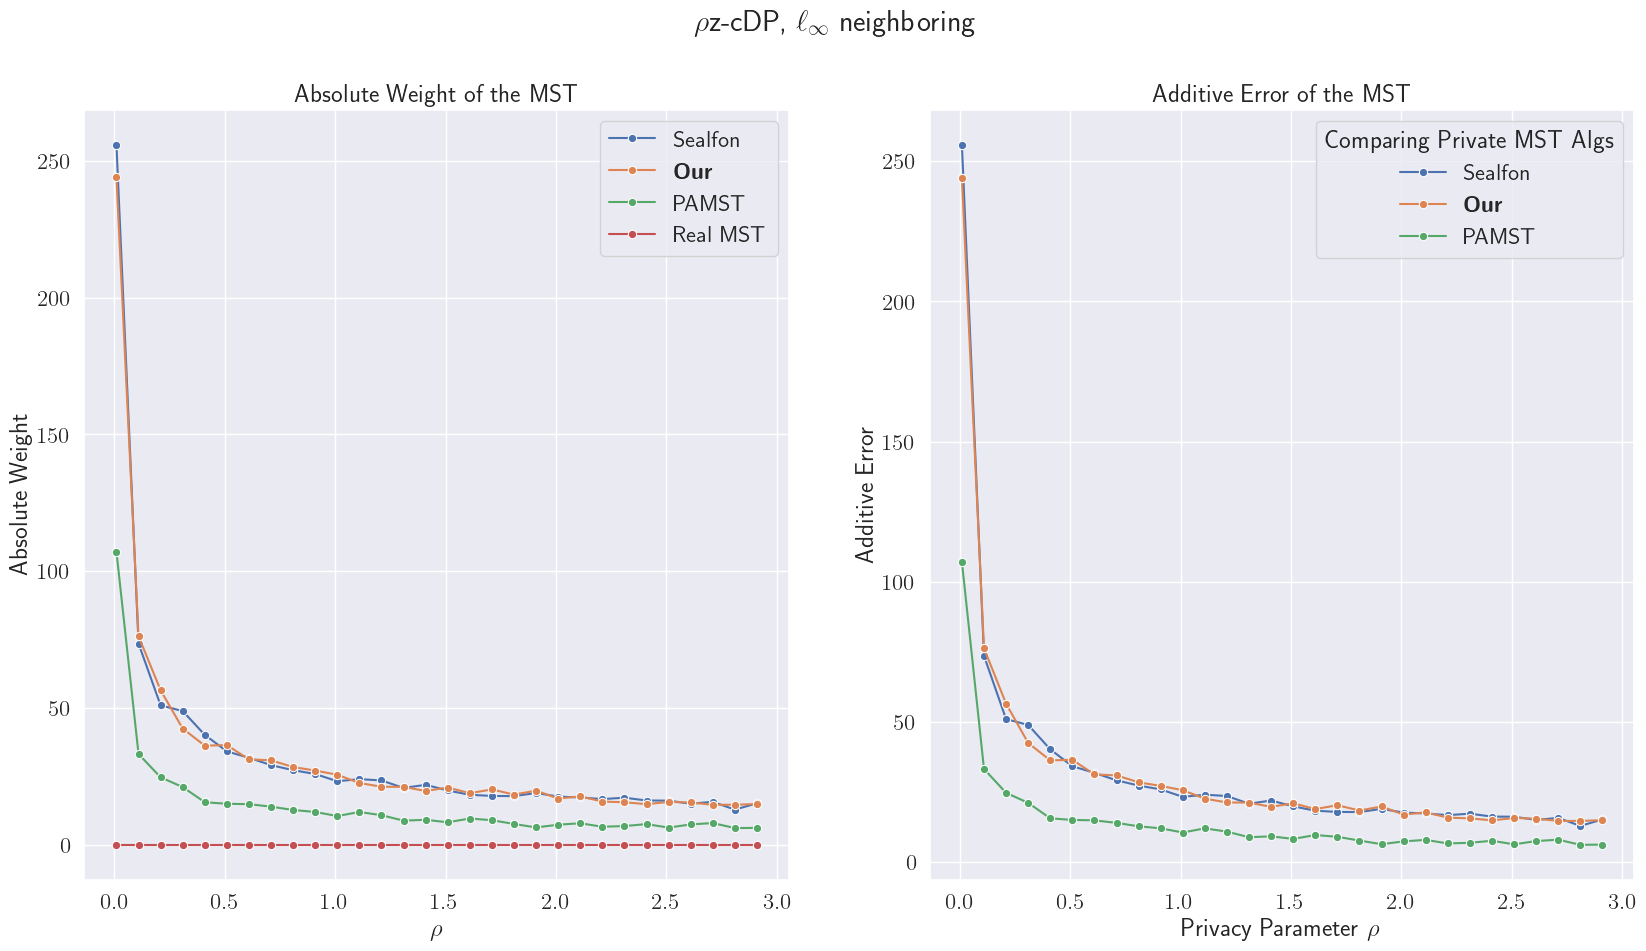

In [73]:
# Constructing an hard instance

# Privacy Parameters
rho_values = np.arange(0.01, 3, 0.1)
# rho_values = [0.001,0.02]
n = 250
sensitivity = 1

# Generate a enw graph
G = {}
for rho in rho_values:
    G[rho] = generate_hard_instance(n, 1/75* math.sqrt((n-1)/(2*rho)))
# Computing the upper bound
upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n)/(2*rho)]
    
results = compute(G, sensitivity=sensitivity,rho_values=rho_values )
(sealfon, our, pamst, real) = (results['sealfon'], results['our'], results['pamst'], results['real'])

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x=rho_values, y=sealfon , marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x=rho_values, y=our, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x=rho_values, y=pamst, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x=rho_values, y=real, marker='o', label="Real MST", ax=axs[0])

# Error of the MST
sns.lineplot(x=rho_values, y=[sealfon - real for sealfon, real in zip(sealfon, real)], marker='o',
             label="Sealfon", ax=axs[1])
sns.lineplot(x=rho_values, y=[ours - real for ours, real in zip(our, real)], marker='o',
             label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x=rho_values, y=[pamst - real for pamst, real in zip(pamst, real)], marker='o',
             label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title="Comparing Private MST Algs")
plt.show()

# Appendix

What comes now is more or less meant for experiments and debugging.

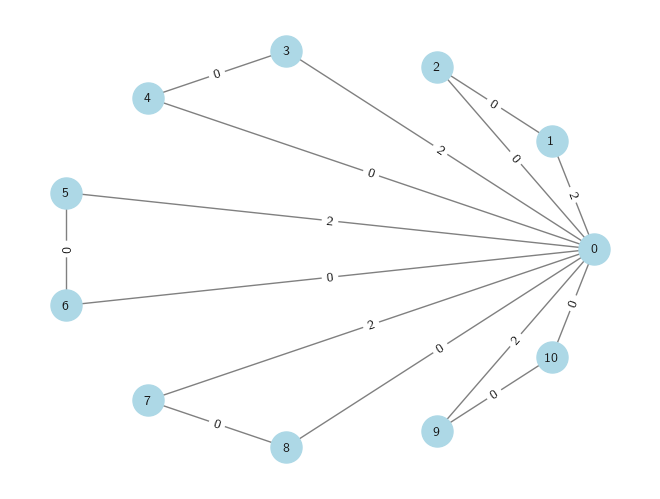

In [17]:
# Visualization of our hard instance
pos = nx.circular_layout(G)

G = generate_hard_instance(5, 1)
T = nx.minimum_spanning_tree(G, algorithm='prim')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.show()


{(0,
  1): Text(-0.19882850523197593, -0.6345080300249896, '-0.9192068641040887'),
 (0,
  2): Text(-0.07087365393847175, -0.42955507614362737, '-0.8596838763959699'),
 (0,
  3): Text(-0.07888746877207485, -0.1447708110222666, '-0.8086059149461139'),
 (0, 4): Text(-0.2550781373439255, 0.1455830414045582, '-0.7631633636805215'),
 (1, 2): Text(0.13274301768718427, -0.3552291889777333, '-0.9192068641040887'),
 (1,
  3): Text(0.12472920285358119, -0.07044492385637255, '-0.8596838763959699'),
 (1,
  4): Text(-0.051461465718269456, 0.21990892857045224, '-0.8086059149461139'),
 (2, 3): Text(0.2526840541470854, 0.13450803002498965, '-0.9192068641040887'),
 (2, 4): Text(0.07649338557523473, 0.42486188245181444, '-0.8596838763959699'),
 (3, 4): Text(0.06847957074163163, 0.7096461475731752, '-0.9192068641040887')}

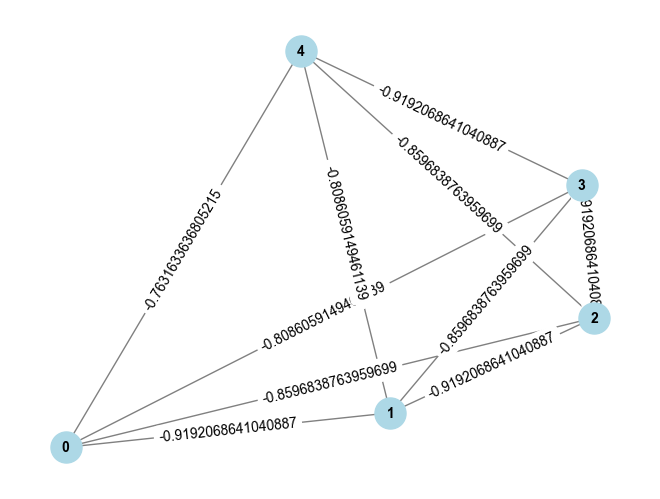

In [2]:
# Visualization MI Cell

G2 = generate_mi_instance(5, 0.01)
pos = nx.spiral_layout(G2)

# Draw the graph
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=10)
